In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2023-01-16 15:36:48.274580


# Poikkeavien arvojen poistaminen tai korvaaminen

Muista selvästi poikkeavat arvot voivat olla virheellisiä tai todellisia.

Jos poikkeavat arvot osoittautuvat virheellisiksi, niin ne on syytä poistaa datasta. Kyseeseen voi tulla poikkeavia arvoja sisältävien rivien poisto, poikkeavien arvojen korvaaminen puuttuvan arvon merkillä tai korvaaminen esimerkiksi mediaanilla.

Vaikka poikkeavat arvot olisivat todellisia, niin niiden poistaminen voi olla aiheellista esimerkiksi ennustemallien rakentamisessa.

Poikkeavien arvojen kriteerinä voidaa pitää esimerkiksi seuraavia:
* Arvot, jotka ovat yli kolmen keskihajonnan päässä keskiarvostaan.
* Arvot, jotka ovat yli 1,5 neljännesvälin päässä neljänneksestä. Neljännesväli (inter quartile range) on yläneljänneksen ja alaneljänneksen erotus. Ruutu- ja janakaavioon (boxplot) yli 1,5 neljännesvälin päässä olevat arvot merkitään oletusarvoisesti erillisinä pisteinä.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Arvotaan normaalijakaumasta satunnaislukuja (tuhat riviä, neljä saraketta)
df = pd.DataFrame(np.random.randn(1000, 4))

In [4]:
df.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.012565,0.025063,-0.000607,0.085266
std,1.012547,0.983394,0.988263,1.006270
min,-3.248166,-3.378623,-3.491847,-2.833924
25%,-0.708346,-0.633167,-0.696937,-0.580844
50%,-0.007899,0.053698,0.030040,0.067205
75%,0.669993,0.685973,0.681056,0.785649
max,3.099975,2.944685,3.230061,3.241910


<AxesSubplot:>

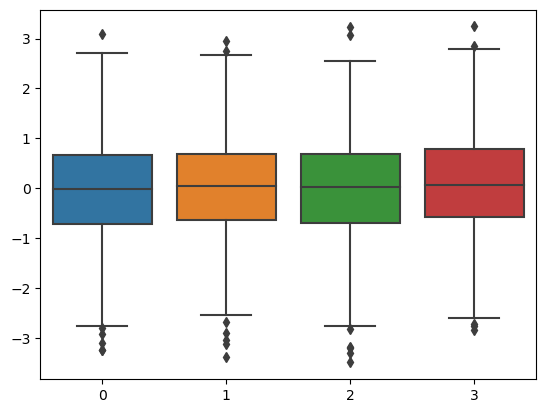

In [5]:
# Katsotaan onko mukana yli 1,5 neljännesvälin päässä neljänneksestä olevia arvoja
# Ne näkyvät boxplotissa erillisinä pisteinä
sns.boxplot(data=df)

## Rivien poisto

In [6]:
# Poistan poikkeavia arvoja (yli 3 keskihajonnan päässä keskiarvostaan) sisältävät rivit

df1 = df.copy()

for muuttuja in df1:
    ka = df[muuttuja].mean()
    kh = df[muuttuja].std()
    # Suodatan mukaan rivit, jotka ovat korkeintaan kolmen keskihajonnan päässä keskiarvostaan
    df1 = df1[abs(df1[muuttuja]-ka) <= 3*kh]

# Tarkistan jäljelle jääneiden rivien lukumäärän
df1.shape[0]

986

In [7]:
# Poistan poikkeavia arvoja (yli 1,5 neljännesväliä neljänneksestä)

df2 = df.copy()

for muuttuja in df2:
    Q1 = df[muuttuja].quantile(0.25) # alaneljännes
    Q3 = df[muuttuja].quantile(0.75) # yläneljännes
    IQR = Q3-Q1 # neljännesväli
    # Suodatan mukaan rivit, jotka ovat korkeintaan 1,5 neljännesvälin päässä keskiarvostaan
    df2 = df2[((df2[muuttuja] >= (Q1-1.5*IQR)) & (df2[muuttuja] <= (Q3 + 1.5*IQR)))]

# Tarkistan jäljelle jääneiden rivien lukumäärän    
df2.shape[0]

975

## Korvaaminen puuttuvalla arvolla

**mask()** on tässä kätevä
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html

In [8]:
# Yli kolmen keskihajonnan päässä keskiarvostaan sijaitsevat puuttuviksi arvoiksi

ka = df.mean()
kh = df.std()

df3 = df.mask(abs((df-ka)/kh) > 3)

# Tarkistan puuttuvien arvojen lukumäärät
df3.isnull().sum()

0    4
1    3
2    6
3    1
dtype: int64

In [9]:
# Yli 1.5 neljännesvälin päässä neljänneksestä sijaitsevat puuttuviksi arvoiksi

Q1 = df.quantile(0.25) # alaneljännes
Q3 = df.quantile(0.75) # yläneljännes
IQR = Q3-Q1

#df4 = df.mask(((df - Q3) / (Q3 - Q1) > 1.5) | ((Q1 - df) / (Q3 - Q1) > 1.5))
df4 = df.mask((df > Q3+1.5*IQR) | (df < Q1-1.5*IQR))

# Tarkistan puuttuvien arvojen lukumäärät
df4.isnull().sum()

0    6
1    7
2    7
3    5
dtype: int64

## Korvaaminen toisella arvolla

In [10]:
# Korvaan poikkeavat arvot keskiarvolla

ka = df.mean()
kh = df.std()

df5 = df.mask((abs((df-ka)/kh)) > 3, other=ka, axis=1)

# Tarkistan min ja max
df5.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.006124,0.034679,0.006281,0.082109
std,0.992496,0.967500,0.955554,1.001297
min,-2.923904,-2.893814,-2.816109,-2.833924
25%,-0.702480,-0.620002,-0.680599,-0.580844
50%,-0.008833,0.053698,0.023269,0.067205
75%,0.669701,0.685973,0.673561,0.782809
max,2.707483,2.944685,2.547125,2.849078


In [11]:
# Korvaan kaikki arvot, jotka ovat itseisarvoltaan yli 3, arvolla 3 tai -3

df6 = df.copy()

# sign tuottaa oikean etumerkin (+/-)
df6[abs(df6) > 3] = np.sign(df6)*3

# Tarkistan min ja max
df6.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.012074,0.025604,0.000285,0.085024
std,1.010433,0.981646,0.983451,1.005540
min,-3.000000,-3.000000,-3.000000,-2.833924
25%,-0.708346,-0.633167,-0.696937,-0.580844
50%,-0.007899,0.053698,0.030040,0.067205
75%,0.669993,0.685973,0.681056,0.785649
max,3.000000,2.944685,3.000000,3.000000


## Lisätietoa

Data-analytiikka Pythonilla: https://tilastoapu.wordpress.com/python/